# Tutorial 5: MCMC

In this tututorial, we will stepthrough implementations of MCMC methods to hopefully gain more intuition of how MCMC works.

## Quick review of motivation:



While MCMC is a class of general sampling algorithms, we will focus on its applications in Bayesian inference. We will study a problem resambling the naive Bayes model that already appeared earlier.

Consider a general probabilistic model:

![](https://revbayes.github.io/tutorials/intro/figures/graphical_model.png)

Here, $\theta$ and $X_i$ can both be groups of random variables with some arbitary interconnection, but they form an overall
 bi-partite structure (e.g. image and label as $x$, neural network weights $\mu$).
We'll apply the standard assumptions here as well.

The variable $\theta$ represents some model parameters that we want to learn, and $x_1$ through $x_N$ are the training data.
Then the first task is to model/compute $p(\mu | x_1, \ldots , x_N)$. For brevity, define $D =  \{x_1, \ldots , x_N\}$.

In various interesting situations we can set-up the distribution $p(\theta)$ (aka the prior) and the likelihoood $p(D|\theta)$ in such a way that the distribution $p(\theta|D)$ (aka the posterior) are given in a closed form. But we are not assuming this here. Instead, using Bayes rule, we get:
$$p(\theta|D) = \frac{p(D|\theta)p(\theta)}{p(D)}$$

The $p(D)$ in the denominator is often intractable, but we have seen exact inference methods such as variable elimination that do not need to explicitly compute it over all $D$. It can be shown that variable elimination has exponential complexity in the number of input variables in the intermediate factors, and similarly for message passing.

Thus, in general, we need approximate inference methods that can give us answers in polynomial time.



**Claim**: A large sample of $\hat{\theta} \sim p(\theta|D)$ is almost as useful as $p(\theta|D)$

For instance, if we want to draw a new sample of $x$ given observed data $p(x|D)$:

$$p(x|D) = \int_{\Theta}p(x|\theta)p(\theta|D)d\theta$$

This expression for $p(x|D)$ is called the **posterior predictive** distribution.

Important point: Having $\hat{\theta}$ drawn from $p(\theta|D)$, we can use ancestral sampling, and simply draw $\hat{x} \sim p(x|\theta=\hat{\theta})$.
The resulting $\hat{x}$ will match the distribution $p(x|D)$, without the need of explicitly computing $p(\mu|D)$.


The sample $\hat{\theta}$ is also sufficient for regression/classification tasks. Suppose that we have a dataset $D=\{(x_i,y_i)\}_{i=1}^{N}$
and the goal is to predict $p(y_{new}|x_{new}, D)$. Our approach is to build a conditional likelihood model $p(y_i|x_i, \theta)$,
choose a prior $p(\theta)$, and write out the joint probability, which in the regression/classification tasks typically is assumed to factorize as follows:

$$p(y_1, ..., y_N, x_1, ..., x_N, \theta) = p(\theta)\prod_{i=1}^{N}p(y_i|x_i,\theta)p(x_i)$$

And since $x$ is observed, we have:
$$p(y_1, ..., y_N, \theta|x_1, ..., x_N) = \prod_{i=1}^{N}p(y_i|x_i,\theta_i)p(\theta_i)$$

Suppose that we have a sample of $\hat{\theta} \sim p(\theta|D)$, then we can empirically estimate the expectation of $y$ on a
new $x$ as follows:

$$E[y|x, D] = \int_{\mathcal{Y}} y p(y|x,D){\rm d}y = \int_{\mathcal{Y}} y \int_{\Theta} p(y,\theta | x, D) {\rm d}\theta {\rm d}y$$

$$=\int_{\mathcal{Y}} y \int_{\Theta} p(y| \theta, x)p(\theta |D) {\rm d}\theta {\rm d}y = \int_{\Theta}p(\theta |D) \left(\int_{\mathcal{Y}} y  p(y| \theta, x){\rm d}y\right) {\rm d}\theta $$

$$=E_{\theta|D}[E_{y|\theta, x}[y]]$$
which can be estimated using $\hat{\theta}$ to parameterize $p(y|x, \theta)$, and then doing simple monte-carlo on $y|x, \theta$.

## Simple example of MCMC with Metropolis-Hastings

MCMC is kind-of doing standard Markov Chain model analysis in reverse. Usually, we start with observed sequential data
and some prior knowledge about the transitions, and then derive for properties like stationarity, transition distribution, etc.

In MCMC, we build a Markov Chain with a specific stationary distribution in mind, and use it to produce sequences of
observed data, only to discard the sequential information (marginalize over time) while keeping the sampled states.

In Bayesian inference setting, the stationary distribution we aim for is the posterior $p(\theta|D)$. The state of the Markov
chain are values of $\theta$, and the feasibility of the approach lies on the fact that we can exactly compute 'likelihood x prior' $\propto p(\theta|D)$.

Recall from the lecture the Metropolis-Hastings algorithm.
- A tentative new state $x'$ is generated from the proposal density $q(x' | x^{(t)})$. We accept the new state with probability
$$
A(x'|x^{(t)}) \;\;=\;\; \min\left\{1,\frac{\tilde p(x')q(x^{(t)} | x')}{\tilde p(x^{(t)}) q(x' | x^{(t)})}\right\}
$$
-  If accepted, set $x^{(t + 1)} = x'$. Otherwise, set $x^{(t + 1)} = x^{(t)}

- Metropolis: Simpler version when $q(x'|x)=q(x|x')$ for all $x,x'$.


We will run MH on a simple model for fitting baseball data. Our training data is 45 initial at-bats and hits for 18 players,
and we will explore different models for predicting the number of hits for the full season.

### Imports and Dataloading

In [4]:
# Importing necessary libraries and functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import beta as B
from scipy.special import binom as nCk
import tqdm
from functools import partial
from IPython.display import display, clear_output

# Reading the dataset from the URL
DATA_URL = "https://www1.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt"
baseball_dataset = pd.read_csv(DATA_URL, sep="\t")


def train_test_split(pd_dataframe):
    """
    Splits the given pandas dataframe into training and testing datasets.

    Training data - 45 initial at-bats and hits for each player.
    Validation data - Full season at-bats and hits for each player.
    """

    # Creating the training data from the 'At-Bats' and 'Hits' columns
    train_data = np.array(
        pd_dataframe[["At-Bats", "Hits"]].values, dtype=float
    )

    # Creating the testing data from the 'SeasonAt-Bats' and 'SeasonHits' columns
    test_data = np.array(
        pd_dataframe[["SeasonAt-Bats", "SeasonHits"]].values,
        dtype=float,
    )

    # Extracting the first and last names of the players
    first_name = pd_dataframe["FirstName"].values
    last_name = pd_dataframe["LastName"].values

    # Creating a list of player names by joining the first and last names
    player_names = [
        " ".join([first, last]) for first, last in zip(first_name, last_name)
    ]

    # Returning the training data, testing data, and player names
    return train_data, test_data, player_names

# Number of players
N = 18

# Splitting the dataset into training and testing datasets, and getting the player names
train, test, pnames = train_test_split(baseball_dataset)

# Printing the training data and player names
print(train)
print(pnames)


[[45. 18.]
 [45. 17.]
 [45. 16.]
 [45. 15.]
 [45. 14.]
 [45. 14.]
 [45. 13.]
 [45. 12.]
 [45. 11.]
 [45. 11.]
 [45. 10.]
 [45. 10.]
 [45. 10.]
 [45. 10.]
 [45. 10.]
 [45.  9.]
 [45.  8.]
 [45.  7.]]
['Roberto Clemente', 'Frank Robinson', 'Frank Howard', 'Jay Johnstone', 'Ken Berry', 'Jim Spencer', 'Don Kessinger', 'Luis Alvarado', 'Ron Santo', 'Ron Swaboda', 'Rico Petrocelli', 'Ellie Rodriguez', 'George Scott', 'Del Unser', 'Billy Williams', 'Bert Campaneris', 'Thurman Munson', 'Max Alvis']


### The model
Let $H_i$ denote the number of hits for player i, and $N_i$ the number of attempts. A natural model for $N$ and $H$ is the
binomial distribution ${\rm Bin}(N, H, \theta) = \binom{N}{H}\theta^{H}(1-\theta)^{N-H}$.

In order to check our implementation, we will use a **conjugate prior** on $\theta$ which gives us analytical expressions for
$p(\theta|D)$. Specifically, we use the beta-distribution, ${\rm Beta}(\theta, \alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$, where $B$ is the beta function.
$\alpha>0$ and $\beta>0$ are hyperparameters for the prior, and $\theta \in [0,1]$.

We have the following expression for $p(\theta|D)$:

$$p(\theta|D) = {\rm Beta}(\theta, \alpha + H, \beta + N - H)$$

Intuitively, $\alpha$ and $\beta$ can be interpreted as the number of hits and misses observed so far.
Initializing $\alpha=\beta=1$, let's code up the model from scratch in numpy:

In [5]:
# Setting the parameters for the Beta distribution
alpha=1.0
beta=1.0

def beta_pmf(p, a, b):
    """
    This function calculates the density of the Beta distribution at p.
    """
    # The np.where function is used to conditionally calculate the density.
    # If p is between 0 and 1 (inclusive), the pmf of the Beta distribution is calculated.
    # If p is not between 0 and 1, a zero is returned.
    return np.where(np.logical_and(p<=1, p>=0), (p**(a-1)*(1-p)**(b-1))/B(a,b), np.zeros_like(p))

def likelihood(x, n, p):
    """
    This function calculates the likelihood of observing x successes in n trials for a given probability p.
    """
    # The likelihood is calculated using the formula for the Binomial distribution.
    return nCk(n, x) * p**x * (1-p)**(n-x)

def get_posterior(x, n, a, b):
    """
    This function returns a function that calculates the posterior distribution.
    """
    def gt_posterior(p):
        # The posterior distribution is calculated using the formula for the Beta distribution,
        # with the shape parameters updated based on the observed data.
        return (p ** (a + x - 1) * (1 - p) ** (b + n - x - 1)) / B(a + x, b + n - x)
    return gt_posterior


Let's just plot the prior and analytical posterior for the first player for now:

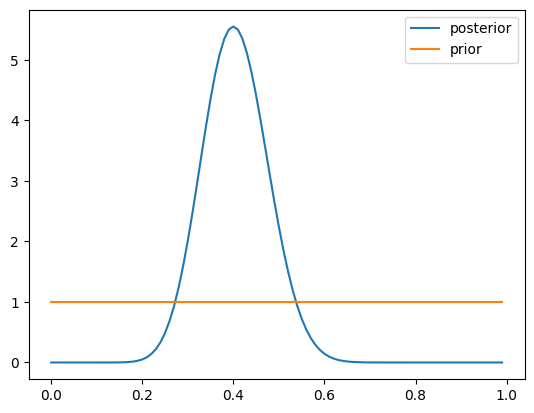

In [6]:
# Define probability range
ps = np.arange(0,1,0.01)

# Get posterior distribution
post = get_posterior(train[0, 1], train[0, 0], alpha, beta)

# Get prior distribution
prior = partial(beta_pmf, a=alpha, b=beta)

# Plot the posterior and the prior distributions
ax = plt.subplot()
ax.plot(ps, post(ps), label='posterior')
ax.plot(ps, prior(ps), label='prior')
ax.legend()


If we have access to this analytical posterior, we can use simple Monte-Carlo to draw samples:

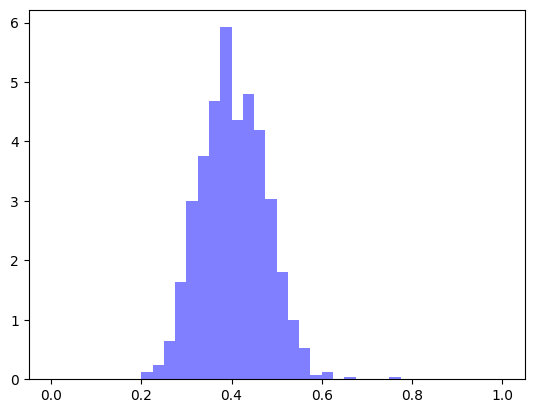

In [7]:
# Perform simple Monte Carlo simulation
simple_MC = np.random.beta(alpha+train[0, 1], beta+train[0, 0]-train[0, 1], 1000)

# Create a subplot
fig, axes = plt.subplots(1,1)

# Plot histogram of the simulation results
axes.hist(simple_MC, bins=40, range=(0,1), density=True, color='blue', alpha=0.5);


To perform Metropolis-Hastings, we still need to specify the proposal distribution $q(x'|x_t)$ ($x$ means $\mu$). In this simple example,
we will let $q(x'|x_t) \sim N(x_t,\sigma)$, with $\sigma$ as a hyperparameter set to $0.2$.

In [8]:
def kernel(p, step_size=0.2):
    return p + np.random.normal(scale=step_size, size=p.size)


We are now ready to step through MH (plotting first 6 players only):

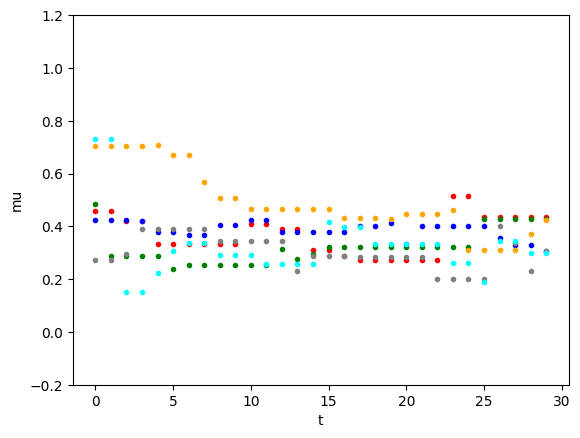

In [9]:
# Initialize parameters
cur_p = np.random.uniform(0, 1.0, size=[18,])
cur_likelihood = likelihood(train[:,1], train[:, 0], cur_p) * beta_pmf(cur_p, alpha, beta)

# Initialize lists for storing samples, log-likelihoods, and acceptance rates
samples = []
LLs = []
accept_rates = []

# Set up the plot
fig,ax = plt.subplots(1,1)
ax.set_xlabel('t')
ax.set_ylabel('mu')
ax.set_ylim(-0.2,1.2)
colors = ['r','g','b','orange','gray','cyan']

# Perform Metropolis-Hastings sampling
for i in range(30):
    # Propose new parameters
    proposed_p = kernel(cur_p)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    # Calculate acceptance probability
    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)

    # Update parameters and likelihood based on acceptance probability
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    # Calculate and store acceptance rate, log-likelihood, and samples
    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    LLs.append(np.log(cur_likelihood).sum())
    samples.append(cur_p)

    # Plot the current parameters
    for p in range(6):
        ax.plot(i, cur_p[p], c=colors[p], marker='.')
    display(fig)
    clear_output(True)
    plt.pause(1.0)


Let's remove plotting and run this for a long time:

In [10]:
for i in tqdm.tqdm(range(2000)):

    proposed_p = kernel(cur_p)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    LLs.append(np.log(cur_likelihood).sum())
    samples.append(cur_p)

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 17029.28it/s]


and compare it versus our analytical solution:

/var/folders/2w/qvx13jnd4k1ckwbcb5679jw40000gn/T/ipykernel_45490/3560318371.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


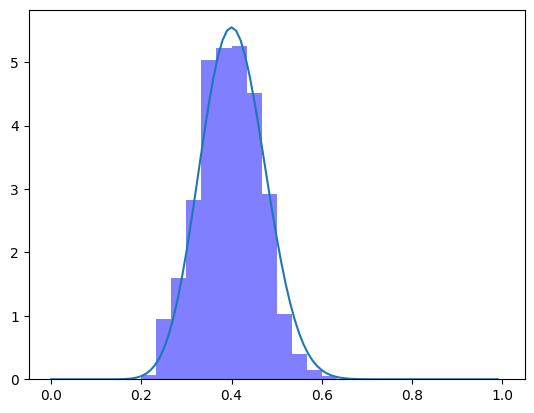

In [11]:
# Discard the first 100 samples
samples = np.array(samples[100:])

# Create a single subplot
fig, axes = plt.subplots(1,1)

# Plot a histogram of the first column of the remaining samples
# The histogram has 30 bins, ranges from 0 to 1, and is normalized (density=True)
axes.hist(samples[:,0], bins=30, range=(0,1), density=True, color='blue', alpha=0.5)

# Create an array of probabilities from 0 to 1 in steps of 0.01
ps = np.arange(0,1,0.01)

# Calculate the posterior probability using the first row of the training data and the alpha and beta parameters
post = get_posterior(train[0, 1], train[0, 0], alpha, beta)

# Plot the posterior probability as a function of the probabilities
axes.plot(ps, post(ps))

# Display the figure
fig.show()


The histogram of the posterior samples matches well the true posterior distribution.

While our example ran reasonably fast, how efficient were we with the steps? A natural metric for efficiency is the
acceptance rate:

In [12]:
print("accept rates", np.mean(accept_rates))


accept rates 0.3588122605363985


At around 30%, we are rejecting most samples produced by our proposal distribution. What would happen if we reduced the
step size from $0.2$ to $0.03$?

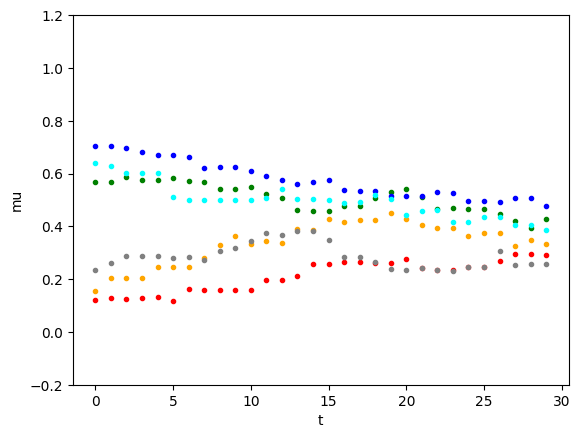

accept rates 0.7592592592592593


In [13]:
cur_p = np.random.uniform(0, 1.0, size=[18,])
cur_likelihood = likelihood(train[:,1], train[:, 0], cur_p) * beta_pmf(cur_p, alpha, beta)
samples = []
LLs = []
accept_rates = []
fig,ax = plt.subplots(1,1)
ax.set_xlabel('t')
ax.set_ylabel('mu')
ax.set_ylim(-0.2,1.2)
colors = ['r','g','b','orange','gray','cyan']
for i in range(30):
    clear_output(True)
    proposed_p = kernel(cur_p, step_size=0.03)
    prop_likelihood = likelihood(train[:,1], train[:, 0], proposed_p) * beta_pmf(proposed_p, alpha, beta)

    # since our proposal probability is clearly symmetric, q(x'|x_t)/q(x_t|x') = 1
    a = prop_likelihood / cur_likelihood
    u = np.random.uniform(0,1, size=cur_p.size)
    cur_p = np.where(a >= u, proposed_p, cur_p)
    cur_likelihood = np.where(a >= u, prop_likelihood, cur_likelihood)

    accept_rate = np.sum(a >= u)/np.size(a)
    accept_rates.append(accept_rate)
    LLs.append(np.log(cur_likelihood).sum())
    samples.append(cur_p)

    #ax.cla()
    y = np.array(samples)

    for p in range(6):
        ax.plot(i, cur_p[p], c=colors[p], marker='.')
    display(fig)

    plt.pause(1.0)

print("accept rates", np.mean(accept_rates))

We see that while accept rate went up, we are making much less progress in reaching high-likelihood regions using the same
amount of steps. One way to describe this phenomenom is that the **mixing time** of our Markov chain has increased, meaning
that it takes longer to reach its stationary distribution (which matches the true posterior).

Nonetheless, we see that changing the proposal distribution can give our Markov chain desirable properties.

## Metropolis-Hastings with Langevin dynamics (a.k.a. Langevin Monte-Carlo LMC)

Intuitively, we want our chain to move to high-probability regions under the posterior. We also happen to have access to
$p(D|\theta)p(\theta)$, which is proportional to $p(\theta|D)$. Hence, **we might get faster convergence if we steer our proposal distribution, in the direction of the gradients of the posterior**, which is also proportional to $p(D|\theta)p(\theta)$.

(This is similar to gradient descent, we don't really care about the magnitude of the gradient, since we are multiplying by the step size (aka learning rate) anyways.)

As we have often seen in MLE, it is more convenient to work with the gradients of the log-likelihood function instead of
the density itself. Hence, we'll write $f(\theta) = - \log \pi(\theta)$, where $\pi(\theta) = p(D|\theta)p(\theta)$. A natural way to define our transition is then:

$$\theta' \;=\; \theta_{t} - \sigma \nabla f(\theta_t) + \sqrt{2\sigma} \xi, $$ with $\xi \sim \mathcal{N}(0,I)$. This is taking the gradient step and adding a random noise term. In other words, the conditional distribution of  $\theta'$ given $\theta_t$ is $N(\theta_t-\sigma\nabla f(\theta_t),2\sigma I)$.

The updates used in vanilla MHMC can be seen as drawn from a $0$-centered Gaussian. Here, the expectation of new update is in the direction
of $\nabla f(\theta)$ with magnitude $\sigma$. The addition of $\sqrt{2\sigma} \xi$ ensures stochasticity, and has origins
in the Wiener process for modeling brownian motion.

Since our proposal update is no longer symmetric, our acceptance probability becomes:

$$\alpha = \frac{\pi(\theta')\exp(-||\theta_t - \theta' + \sigma\nabla f(\theta')||_2^2/4\sigma)}{\pi(\theta_t)\exp(-||\theta' - \theta_t + \sigma\nabla f(\theta_t)||_2^2/4\sigma)}$$


### Gaussian Example
Let us use LMC to draw samples from a Gaussian distribution (without explicitly drawing from it).

For gaussians, we have $p(x) \propto \exp(-\|x-\theta\|_2^2)$, thus the negative loglikelihood can be as $f(x) = \|x - \theta\|^2/2 + C$
and $\nabla f(x) = x-\theta$.

Let's first see a version of LMC without the Metropolis-Hasting adjustment:

In [14]:
# Define auxiliary functions
def f(x):
    return .5 * np.sum(x**2)

def df(x):
    return x

# Define the Langevin Monte Carlo (LMC) function
def lmc(x0, eta, max_iter, trace_plot=False):
    x = x0
    trace = np.empty(shape=[0, 2])
    for it in range(max_iter):
        # Calculate the change in x (delta)
        delta = - eta * df(x) + np.sqrt(2 * eta) * np.random.normal(0, 1, len(x))
        # Update x
        x_ = x + delta
        # Add the new x to the trace
        trace = np.vstack([trace, x])
        # If trace_plot is True, plot the trace
        if trace_plot:
            ax.arrow(x[0], x[1], delta[0], delta[1])
            ax.plot(x[0], x[1], marker='.')
            display(fig)
            plt.pause(1.0)
            clear_output(True)
        # Update x
        x = x_
    return trace

x0 = np.array([10., 10.])
# Set the learning rate (eta)
eta = .01
# Set the maximum number of iterations to 12000
max_iter = 12000
# Run the LMC function for 12000 iterations without plotting the trace
path_lmc_full = lmc(x0, eta, max_iter, trace_plot=False)


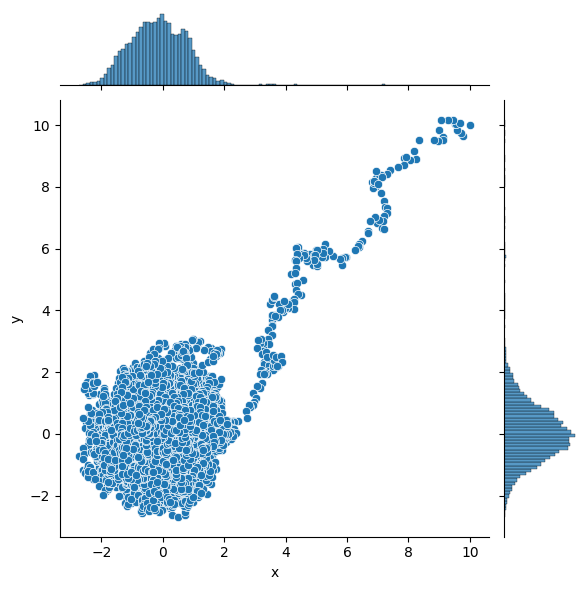

In [15]:
import pandas as pd
import seaborn as sns
dataf = pd.DataFrame(path_lmc_full, columns = ['x','y'])
sns.jointplot(data=dataf, x="x", y="y")


Now let's add the rate calculation and rejection scheme:

In [16]:
# Define the Langevin Monte Carlo with Metropolis-Hastings (LMC-MH) function
def lmcMH(x0, eta, max_iter, trace_plot=False):
    x = x0
    trace = np.empty(shape=[0, 2])
    for it in range(max_iter):
        # Calculate the change in x (delta)
        delta = - eta * df(x) + np.sqrt(2 * eta) * np.random.normal(0, 1, len(x))
        # Update x
        x_ = x + delta
        # Calculate the acceptance rate
        rate = np.exp(f(x)-f(x_) + np.sum(-delta + eta*df(x))/(4*eta) - np.sum(delta + eta*df(x_))/(4*eta))
        print(rate)
        # Generate a random number between 0 and 1
        u = np.random.uniform()
        # If u is less than the acceptance rate, accept the new x
        accept =  u < rate
        # Add the new x to the trace
        trace = np.vstack([trace, x])
        # If trace_plot is True, plot the trace
        if trace_plot:
            # If the new x is accepted, plot the arrow in green, otherwise plot it in red
            if accept:
                ax.arrow(x[0], x[1], delta[0], delta[1], color='g')
            else:
                ax.arrow(x[0], x[1], delta[0], delta[1], color='r')
            # Plot the current x
            ax.plot(x[0], x[1], marker='.')
            # Display the figure
            display(fig)
            # Pause for 1 second
            plt.pause(1.0)
            # Clear the output
            clear_output(True)
        # If the new x is accepted, update x
        if accept:
            x = x_
    # Return the trace
    return trace

# Initialize x0
x0 = np.array([10., 10.])
# Set the learning rate (eta)
eta = .01
# Set the maximum number of iterations
max_iter = 12000
# Run the LMC-MH function for 12000 iterations without plotting the trace
path_lmcmh_full = lmcMH(x0, eta, max_iter, trace_plot=False)


669.5274048593868
13989643329747.988
1805554.8168286493
0.04817986565902296
2155356834.0128875
5467.514067904505
349.63023379446054
4.73360995698582
58.52369939001475
0.0001551328670373631
12360.726110991467
14.088088402352877
2.260830834109889e+16
19739.674517052128
226278.67467074777
242042832.6330125
13553292.381441483
497.5608428550611
174.53610804947164
0.4634981347666767
147336407.58824444
112354.30416814674
3.0393069012052368e-05
6389456208.235737
1109191.5571999007
185.30608414711887
7.234796857043828e-09
6.522009111996552e-07
8124985560842322.0
767.6478370599762
7871.004280508603
1.1854986162208147e-06
399561.34954126144
7419240.630611795
29.74645027928739
148521081.27319962
33096019.479972918
1077.0257113423554
253.05527671964018
0.00011416228765722012
18.498234410038798
360.44395272751166
0.00043059996618045117
6849581.240120623
104080.81533811211
84898233071.67627
69213717.22640403
6.020322732375991
0.08996795180254404
407.4253217092091
0.5364931396493426
2488442.6375616207

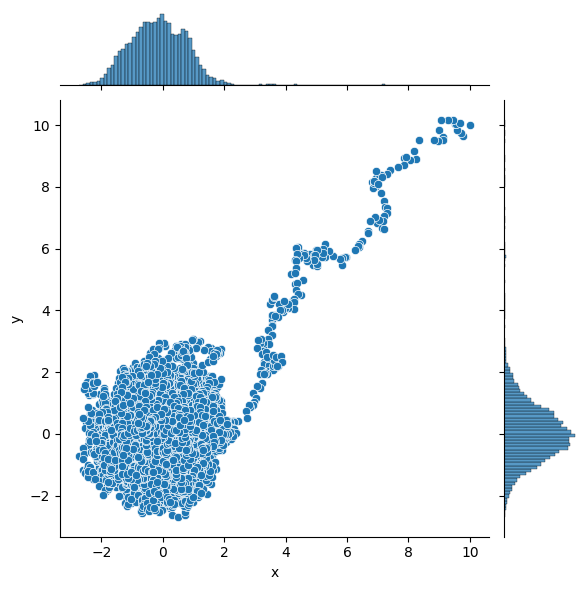

In [17]:
import pandas as pd
import seaborn as sns
dataf = pd.DataFrame(path_lmc_full, columns = ['x','y'])
sns.jointplot(data=dataf, x="x", y="y")


Langevin dynamics in LMC was originally derived from the stochastic equations that describe motion of brownian particles within a potential well.
A key simplifying assumption here was that brownian particles had no inertia - instantaneous changes in velocity is allowed.
A more reallistic model, with kinetic energy also taken into account, is the hamiltonian dynamics model. This in turn inspires
hamiltonian monte-carlo, which is based on hamiltonian dynamics.

(A little spoiler: instead of adding noise to velocity, HMC adds noise to acceleration)

Cool demo: https://chi-feng.github.io/mcmc-demo/